In [1]:
# https://pytorch.org/hub/nvidia_deeplearningexamples_waveglow/
# https://arxiv.org/pdf/1811.00002.pdf
import torch
import numpy as np
from scipy.io.wavfile import write

In [2]:
from librosa.display import specshow
import matplotlib.pyplot as plt

def plot_spec(spec, sr):
    plt.figure(figsize=(10, 4))
    specshow(spec, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar()
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

In [3]:
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
_ = waveglow.eval()

Using cache found in /home/matt/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


In [4]:
tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2')
tacotron2 = tacotron2.to('cuda')
_ = tacotron2.eval()

Using cache found in /home/matt/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


In [5]:
text = """
However, your coming just at this time is the greatest of comforts,
and I am very glad to hear what you tell us, of long sleeves.
"""

In [6]:
# preprocessing
sequence = np.array(tacotron2.text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.from_numpy(sequence).to(device='cuda', dtype=torch.int64)

In [7]:
with torch.no_grad():
    _, mel, _, _ = tacotron2.infer(sequence)

In [8]:
mel.shape, mel.dtype, mel

(torch.Size([1, 80, 806]),
 torch.float32,
 tensor([[[-7.4405, -7.9220, -7.8608,  ..., -9.1588, -9.0931, -8.6147],
          [-6.9035, -7.1915, -7.0272,  ..., -7.6888, -7.6553, -7.4946],
          [-6.4245, -6.5170, -6.0660,  ..., -6.5456, -6.5506, -6.5537],
          ...,
          [-7.7261, -7.6719, -7.6866,  ..., -7.8792, -8.2169, -8.5993],
          [-7.6657, -7.6686, -7.6067,  ..., -8.3931, -8.6379, -8.9429],
          [-7.6821, -7.7071, -7.5853,  ..., -8.6257, -8.7701, -9.0364]]],
        device='cuda:0'))

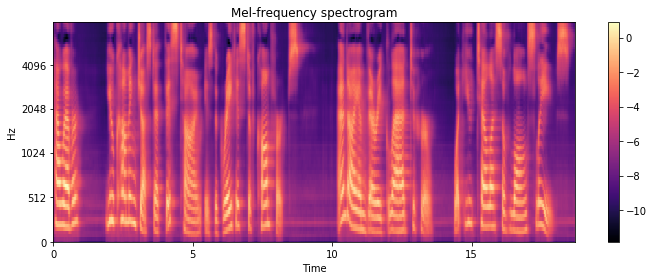

In [9]:
plot_spec(mel.cpu().detach().view(80, -1).numpy(), sr=22050)

In [10]:
with torch.no_grad():
    audio = waveglow.infer(mel)

In [11]:
from IPython.display import Audio
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050
Audio(audio_numpy, rate=rate)

### Waveglow Inputs

We use a sampling rate of 22,050kHz.
We use the mel-spectrogram of the original audio as the input to the WaveNet and WaveGlow networks.

For WaveGlow, 

- we use mel-spectrograms with 80 bins 
- using librosa mel filter defaults i.e. each bin is normalized by the filter length and the scale is the same as HTK
- the parameters of the melspectrograms are FFT size 1024, hop size 256, and window size 1024
"""


In [12]:
import torch
import numpy as np
from scipy import signal
from librosa.feature import melspectrogram
from librosa.feature.inverse import mel_to_audio

In [13]:
from src.datasets import NoisySpectralSpeechDataset
NoisySpectralSpeechDataset.SAMPLING_RATE = 48000
NoisySpectralSpeechDataset.MAX_AUDIO_LENGTH = 3 * 47360
dataset = NoisySpectralSpeechDataset(train=False, quiet=True)

In [14]:
IDX = 2
clean_arr = dataset.clean_data[IDX]
noisy_arr = dataset.noisy_data[IDX]

In [15]:
clean_arr = clean_arr / clean_arr.max()
clean_arr

array([-0.00390625, -0.00378418, -0.00372314, ...,  0.        ,
        0.        ,  0.        ])

In [31]:
# SAMPLING_RATE = 16000
SAMPLING_RATE = 48000

WG_BINS = 80
WG_N_FFT = 1024 # timesteps
WG_HOP = 256 # timesteps
WG_WINDOW = 1024 # timesteps
WG_SAMPLING_RATE = 22050

# Scale based on SR
# N_FFT = WG_N_FFT * SAMPLING_RATE // WG_SAMPLING_RATE
# WINDOW = WG_WINDOW * SAMPLING_RATE // WG_SAMPLING_RATE
# HOP = WG_HOP * SAMPLING_RATE // WG_SAMPLING_RATE

# Use WaveGlow default
# SAMPLING_RATE = WG_SAMPLING_RATE
# N_FFT = WG_N_FFT
# WINDOW = WG_WINDOW
# HOP = WG_HOP

# Just make it up
# N_FFT = 4000
# WINDOW = 4000
# HOP = 1000


# LIBROSA_SPEC_KWARGS = {
#     "sr": SAMPLING_RATE,
#     "n_fft": N_FFT,
#     "hop_length": HOP,
#     "win_length": WINDOW,
#     "n_mels": WG_BINS,
# }
# LIBROSA_SPEC_KWARGS


from librosa.core import resample
print(clean_arr.shape)
clean_arr_resampled = resample(clean_arr, SAMPLING_RATE, WG_SAMPLING_RATE)
print(clean_arr_resampled.shape)
LIBROSA_SPEC_KWARGS = {
    "sr": WG_SAMPLING_RATE,
    "n_fft": WG_N_FFT,
    "hop_length": WG_HOP,
    "win_length": WG_WINDOW,
    "n_mels": WG_BINS,
}
LIBROSA_SPEC_KWARGS

(142080,)
(65268,)


{'sr': 22050,
 'n_fft': 1024,
 'hop_length': 256,
 'win_length': 1024,
 'n_mels': 80}

In [18]:
import torch

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression(x, C=1):
    return torch.exp(x) / C

def audio_to_spec(arr):
    mel_spec = melspectrogram(arr, power=1, **LIBROSA_SPEC_KWARGS)
    spec_post = dynamic_range_compression(torch.Tensor(mel_spec)).numpy()
    mel = torch.Tensor(spec_post).view(1, 80, -1).cuda()
    return mel
    
def spec_to_audio(spec_t):
    with torch.no_grad():
        audio_t = waveglow.infer(spec_t)
        
    audio_arr = audio_t[0].data.cpu().numpy()
    return audio_arr

In [24]:
input_arr = clean_arr_resampled
print(input_arr.shape)
spec_t = audio_to_spec(input_arr)
print(spec_t.shape, spec_t)
output_arr = spec_to_audio(spec_t)
print(output_arr.shape)

(65268,)
torch.Size([1, 80, 255]) tensor([[[ -4.0776,  -3.2962,  -3.4374,  ..., -11.5129, -11.5129, -11.5129],
         [ -4.2608,  -3.7211,  -4.1576,  ..., -11.5129, -11.5129, -11.5129],
         [ -4.2410,  -4.6916,  -5.3700,  ..., -11.5129, -11.5129, -11.5129],
         ...,
         [ -9.1789,  -9.3486,  -9.5516,  ..., -11.5129, -11.5129, -11.5129],
         [ -9.2298,  -9.5378,  -9.7575,  ..., -11.5129, -11.5129, -11.5129],
         [ -8.8631,  -9.5171, -10.7053,  ..., -11.5129, -11.5129, -11.5129]]],
       device='cuda:0')
(65280,)


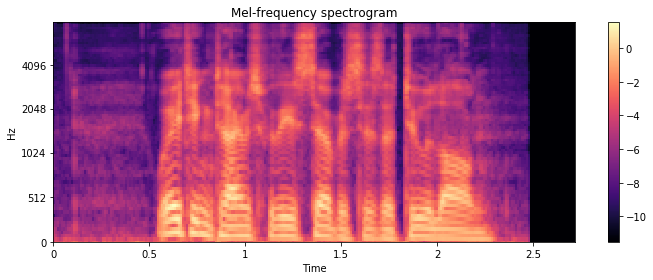

In [25]:
plot_spec(spec_t.cpu().detach().view(80, -1).numpy(), sr=48000)

In [30]:
from IPython.display import Audio
print(output_arr.shape, len(output_arr) / 22050)
Audio(output_arr, rate=22050)

(65280,) 2.9605442176870747


In [29]:
print(input_arr.shape, len(input_arr) / 22050)
Audio(input_arr, rate=22050)

(65268,) 2.96
